In [9]:
import pandas as pd
from IPython.display import display

def graph_summary_table(graph, subgraphs, m):
    """
    Prints a table summarizing the graph and its subgraphs.

    Parameters
    ----------
    graph : networkx.Graph
        The full graph.
    subgraphs : list of networkx.Graph
        List of subgraphs.
    m : int
        The minimum degree used for gamma estimation.
    """
    rows = []

    # --- Precompute modularity of the partition ---
    partition = [list(sg.nodes()) for sg in subgraphs]
    modularity_val = nx.algorithms.community.modularity(graph, partition)

    # Full graph summary
    rows.append({
        "Graph": "Full Graph",
        "Order": graph.number_of_nodes(),
        "Size": graph.number_of_edges(),
        "Connected": nx.is_connected(graph),
        "Gamma": f"{estimate_gamma(graph, m):.2f}",
        "Clustering": f"{nx.average_clustering(graph):.2f}",
        "Modularity": f"{modularity_val:.2f}",
    })

    # Subgraphs summaries
    for i, sg in enumerate(subgraphs):
        rows.append({
            "Graph": f"Subgraph {i+1}",
            "Order": sg.number_of_nodes(),
            "Size": sg.number_of_edges(),
            "Connected": nx.is_connected(sg),
            "Gamma": f"{estimate_gamma(sg, m):.2f}",
            "Clustering": f"{nx.average_clustering(sg):.2f}",
            "Modularity": "N/A"  # Subgraph modularity not meaningful
        })

    # Create and display the DataFrame
    df = pd.DataFrame(rows)
    display(df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]},
    ]).set_properties(**{'text-align': 'center'}))


------------------------  Groups assigned by random shuffling  ------------------------

Erdös-Renyí graph with random subgraphs


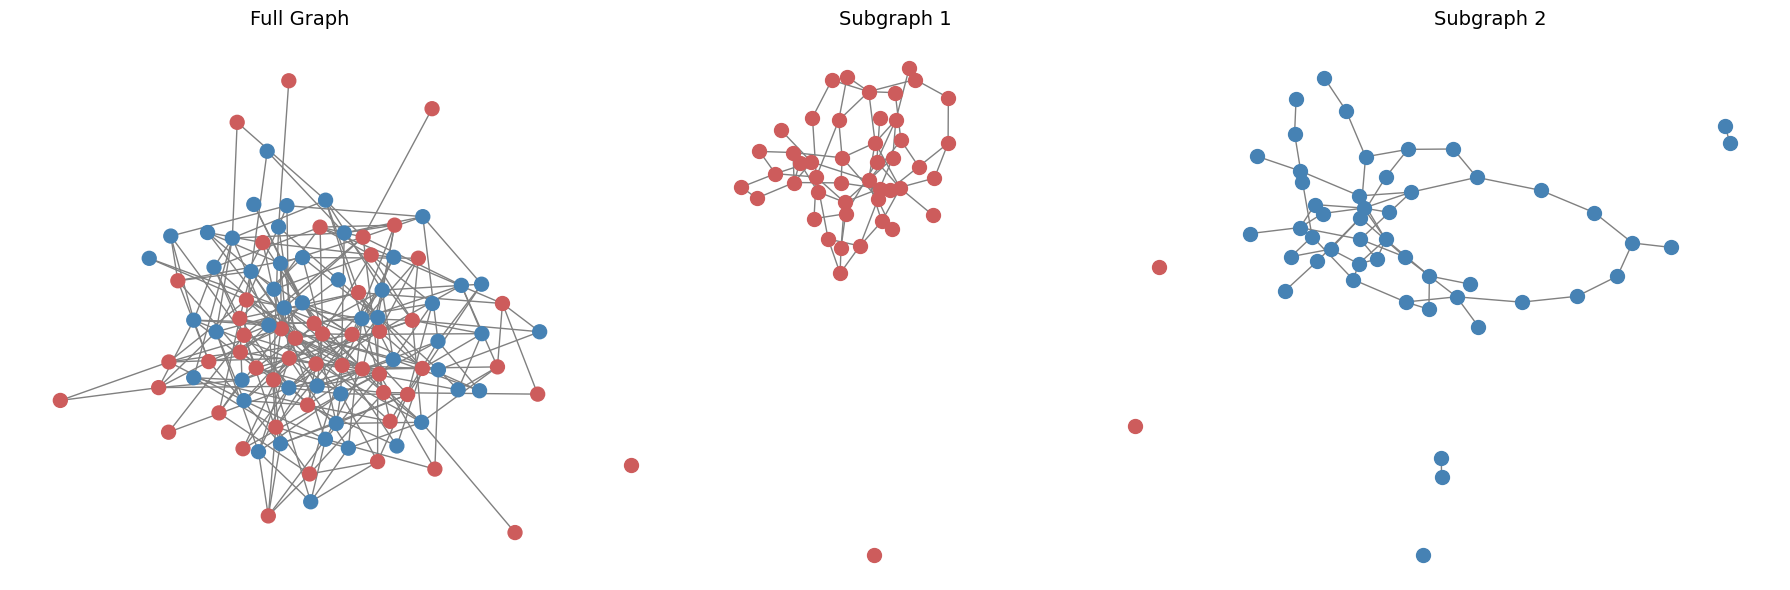

,Graph,Order,Size,Connected,Gamma,Clustering,Modularity
0,Full Graph,100,291,True,2.15,0.06,-0.04
1,Subgraph 1,50,74,False,3.10,0.05,N/A
2,Subgraph 2,50,61,False,3.70,0.02,N/A



Barabási-Albert graph with random subgraphs


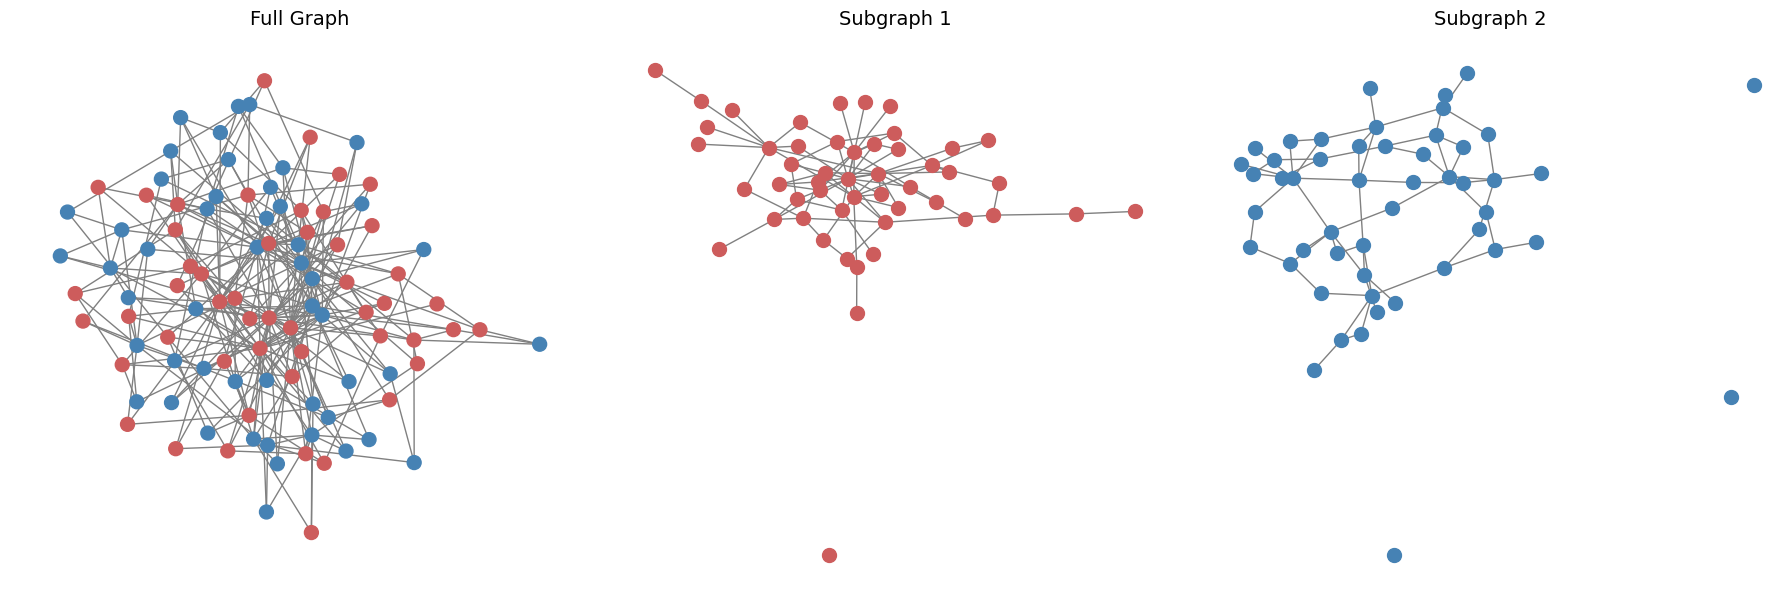

,Graph,Order,Size,Connected,Gamma,Clustering,Modularity
0,Full Graph,100,291,True,2.53,0.18,-0.01
1,Subgraph 1,50,81,False,2.63,0.14,N/A
2,Subgraph 2,50,62,False,3.14,0.11,N/A



------------------------  Groups assigned by spectral partitioning  ------------------------

Erdös-Renyí graph with spectral subgraphs


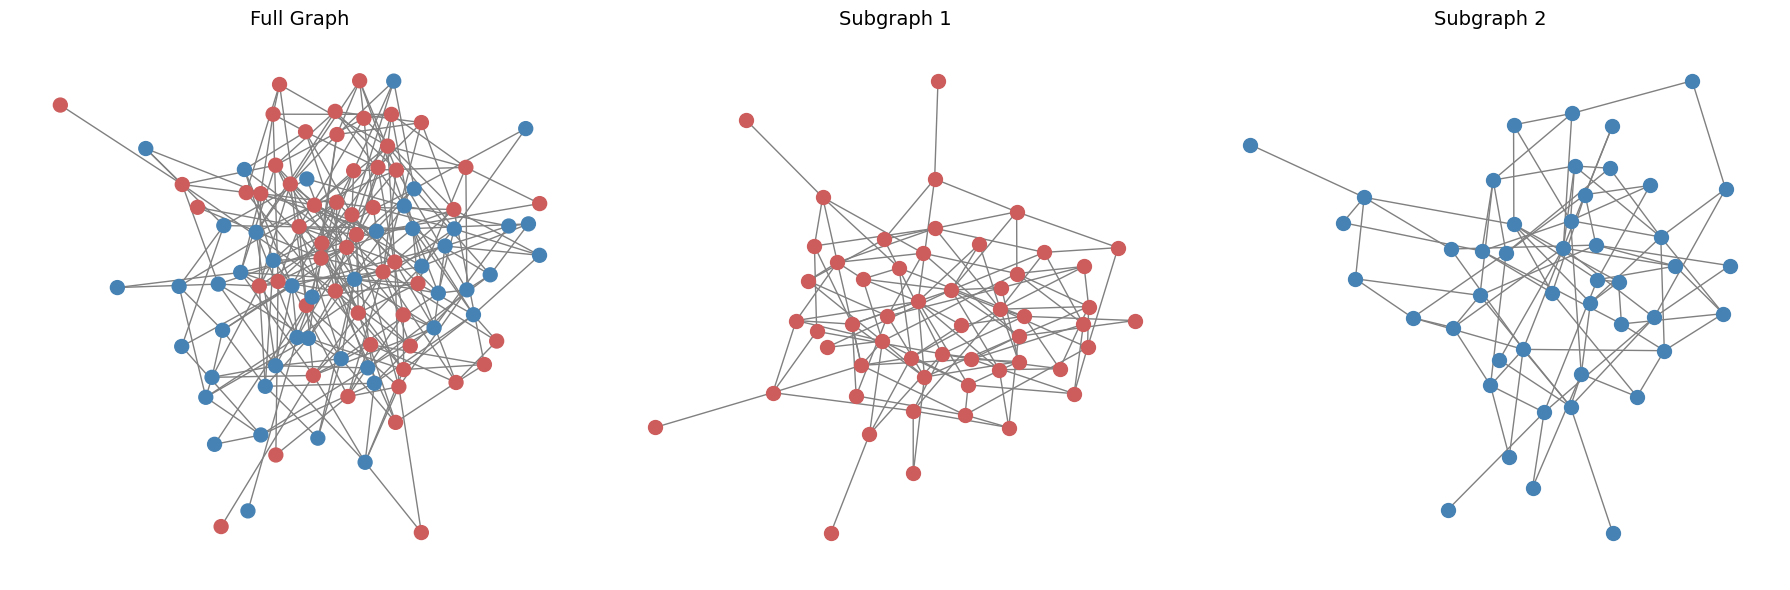

,Graph,Order,Size,Connected,Gamma,Clustering,Modularity
0,Full Graph,100,291,True,2.15,0.06,0.25
1,Subgraph 1,54,129,True,2.44,0.05,N/A
2,Subgraph 2,46,92,True,2.71,0.07,N/A



Barabási-Albert graph with spectral subgraphs


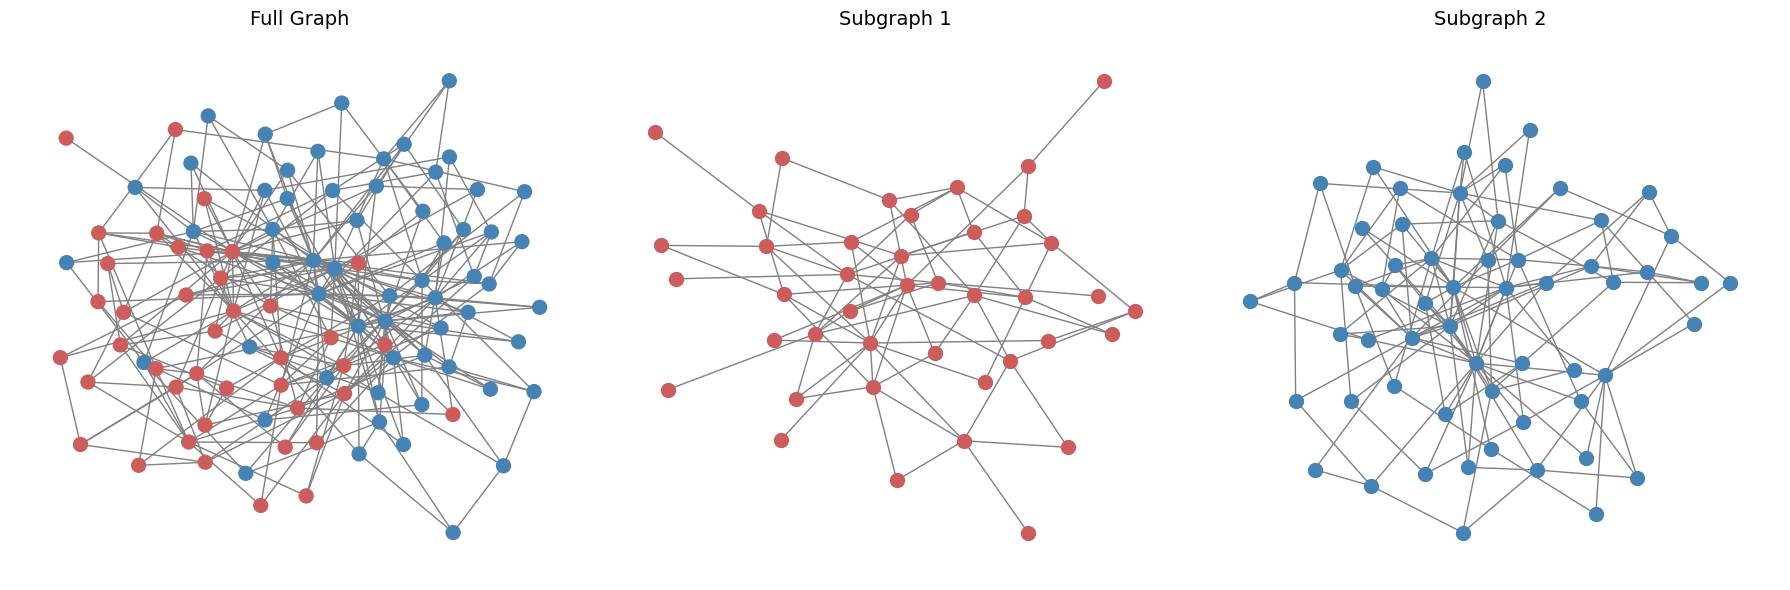

,Graph,Order,Size,Connected,Gamma,Clustering,Modularity
0,Full Graph,100,291,True,2.53,0.18,0.23
1,Subgraph 1,41,78,True,2.55,0.14,N/A
2,Subgraph 2,59,143,True,2.69,0.23,N/A



------------------------  Groups assigned by modularity partitioning  ------------------------

Erdös-Renyí graph with modular subgraphs


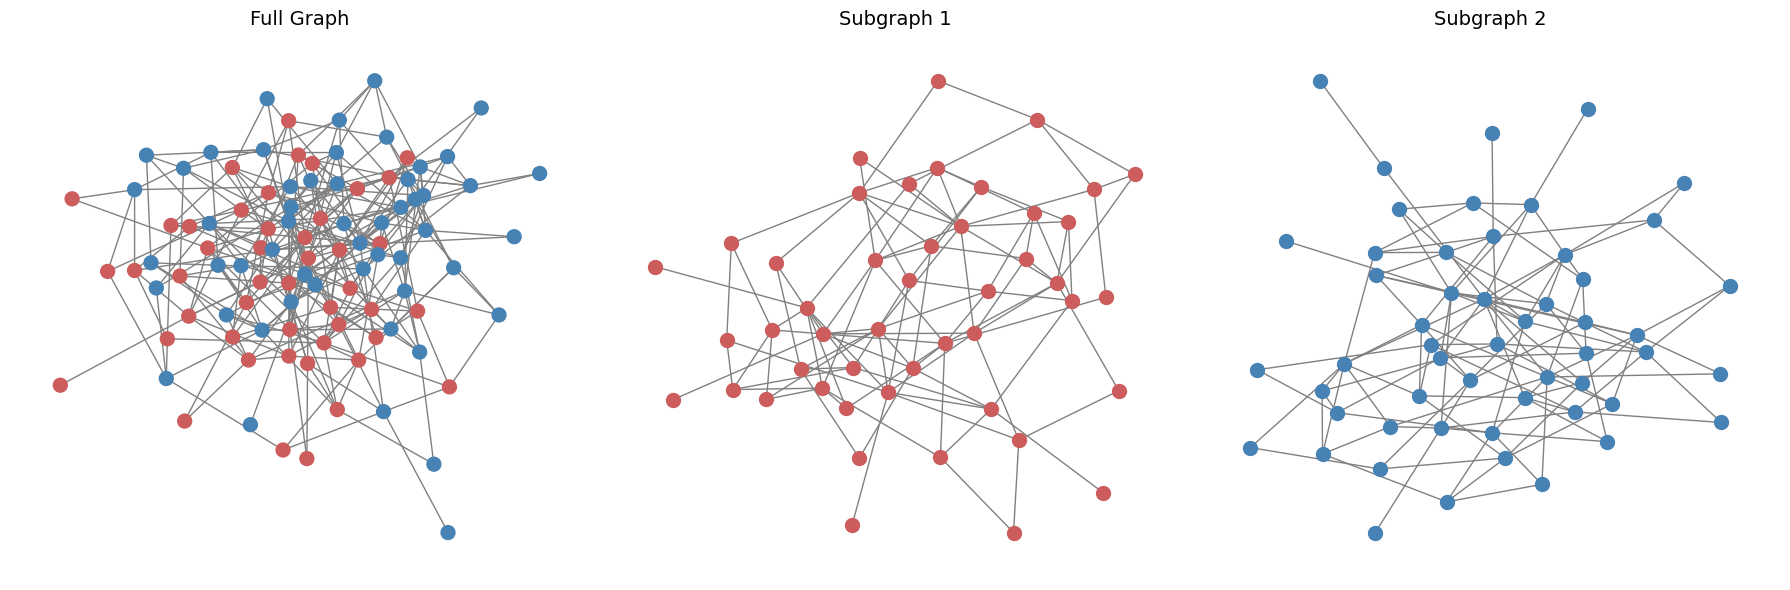

,Graph,Order,Size,Connected,Gamma,Clustering,Modularity
0,Full Graph,100,291,True,2.15,0.06,0.25
1,Subgraph 1,47,101,True,2.55,0.09,N/A
2,Subgraph 2,53,117,True,2.49,0.12,N/A



Barabási-Albert graph with modular subgraphs


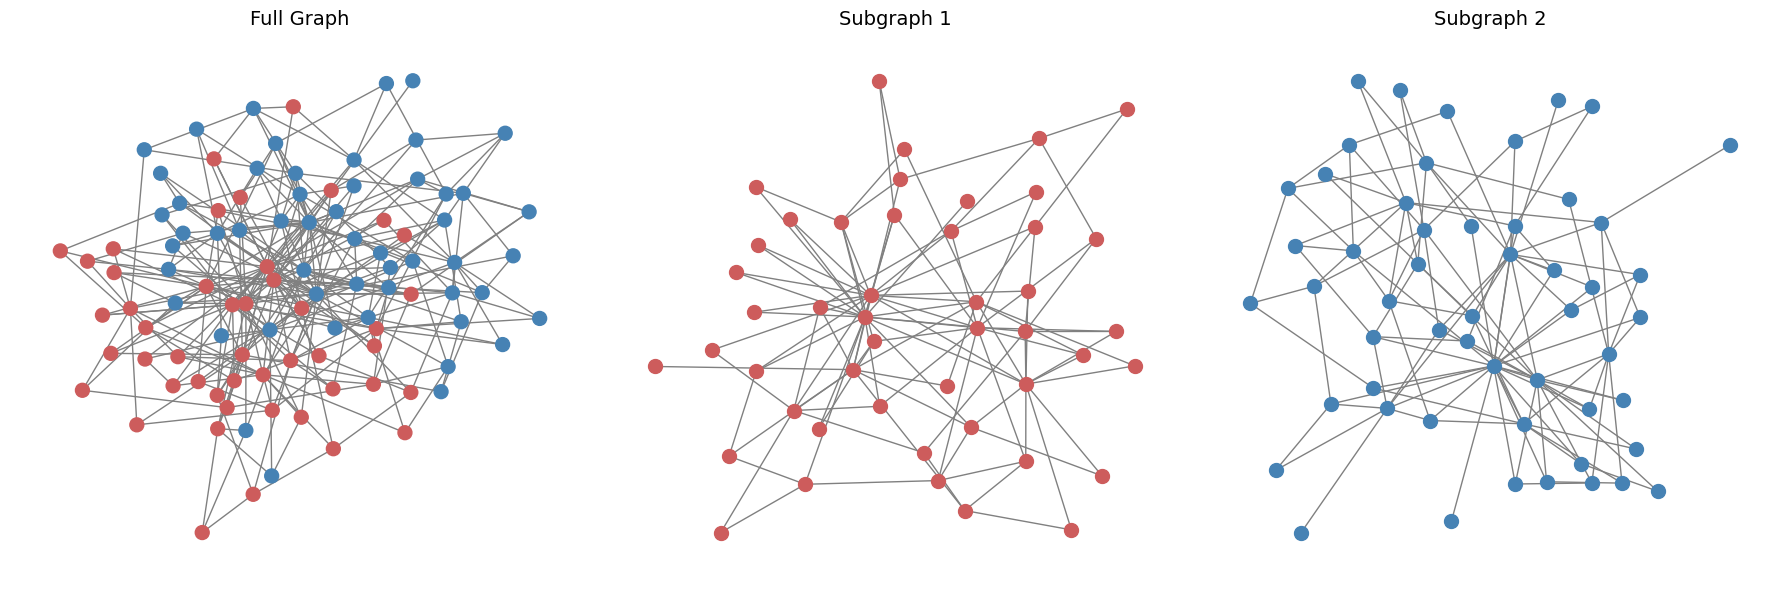

,Graph,Order,Size,Connected,Gamma,Clustering,Modularity
0,Full Graph,100,291,True,2.53,0.18,0.24
1,Subgraph 1,47,103,True,2.40,0.32,N/A
2,Subgraph 2,53,114,True,2.62,0.23,N/A


In [10]:
# Set parameters
n = 100
m = 3
ratios = [1, 1]

# Generate graphs
ER, BA = generate_networks(n, m)

# RANDOM AFFILIATION
print()
print("-" * 24, " Groups assigned by random shuffling ", "-" * 24)
print()

# --- ER Random Subgraphs ---
subgraphs = random_subgraphs(ER, ratios)
print('Erdös-Renyí graph with random subgraphs')
subgraph_plot(ER, subgraphs)
graph_summary_table(ER, subgraphs, m)

# --- BA Random Subgraphs ---
subgraphs = random_subgraphs(BA, ratios)
print('\nBarabási-Albert graph with random subgraphs')
subgraph_plot(BA, subgraphs)
graph_summary_table(BA, subgraphs, m)

# SPECTRAL PARTITIONING
print()
print("-" * 24, " Groups assigned by spectral partitioning ", "-" * 24)
print()

# --- ER Spectral Subgraphs ---
subgraphs = spectral_subgraphs(ER)
print('Erdös-Renyí graph with spectral subgraphs')
subgraph_plot(ER, subgraphs)
graph_summary_table(ER, subgraphs, m)

# --- BA Spectral Subgraphs ---
subgraphs = spectral_subgraphs(BA)
print('\nBarabási-Albert graph with spectral subgraphs')
subgraph_plot(BA, subgraphs)
graph_summary_table(BA, subgraphs, m)

# MODULARITY PARTITIONING
print()
print("-" * 24, " Groups assigned by modularity partitioning ", "-" * 24)
print()

# --- ER Modularity Subgraphs ---
subgraphs = modular_subgraphs(ER)
print('Erdös-Renyí graph with modular subgraphs')
subgraph_plot(ER, subgraphs)
graph_summary_table(ER, subgraphs, m)

# --- BA Modularity Subgraphs ---
subgraphs = modular_subgraphs(BA)
print('\nBarabási-Albert graph with modular subgraphs')
subgraph_plot(BA, subgraphs)
graph_summary_table(BA, subgraphs, m)

Given that real-world networks tend to have a high level of clustering and modularity simultaneously yet our networks have been generated to model community structure only as a secondary property, it is natural to ask to what extent our two deterministic methods of partition produce similar partitions.

In [11]:
import numpy as np
import networkx as nx
from scipy.stats import chi2_contingency

def label_from_partition(subgraphs, n_nodes):
    labels = np.empty(n_nodes, dtype=int)
    for i, sg in enumerate(subgraphs):
        for node in sg.nodes:
            labels[node] = i
    return labels

def binary_contingency_table(labels1, labels2):
    a = np.sum((labels1 == 0) & (labels2 == 0))
    b = np.sum((labels1 == 0) & (labels2 == 1))
    c = np.sum((labels1 == 1) & (labels2 == 0))
    d = np.sum((labels1 == 1) & (labels2 == 1))
    return a, b, c, d

def phi_coefficient(a, b, c, d):
    numerator = a * d - b * c
    denominator = np.sqrt((a + b) * (a + c) * (b + d) * (c + d))
    return 0.0 if denominator == 0 else numerator / denominator

# Parameters
n = 400
k_trials = 10

phi_scores_ER = []
pvals_ER = []
phi_scores_BA = []
pvals_BA = []

for trial in range(1, k_trials + 1):
    ER, BA = generate_networks(n)

    spec_ER = spectral_subgraphs(ER)
    mod_ER = modular_subgraphs(ER)
    spec_BA = spectral_subgraphs(BA)
    mod_BA = modular_subgraphs(BA)

    spec_ER_labels = label_from_partition(spec_ER, n)
    mod_ER_labels = label_from_partition(mod_ER, n)
    spec_BA_labels = label_from_partition(spec_BA, n)
    mod_BA_labels = label_from_partition(mod_BA, n)

    a, b, c, d = binary_contingency_table(spec_ER_labels, mod_ER_labels)
    table_ER = np.array([[a, b], [c, d]])
    phi_ER = phi_coefficient(a, b, c, d)
    chi2_ER, p_ER, _, _ = chi2_contingency(table_ER)

    a, b, c, d = binary_contingency_table(spec_BA_labels, mod_BA_labels)
    table_BA = np.array([[a, b], [c, d]])
    phi_BA = phi_coefficient(a, b, c, d)
    chi2_BA, p_BA, _, _ = chi2_contingency(table_BA)

    phi_scores_ER.append(phi_ER)
    pvals_ER.append(p_ER)
    phi_scores_BA.append(phi_BA)
    pvals_BA.append(p_BA)

# --- Mean results ---
print("\n" + "="*20 + " Mean Results Over All Trials " + "="*20)
print("\nER Graphs:")
print("  Mean Phi Coefficient :", round(np.mean(phi_scores_ER), 4))
print("  Mean Chi² p-value    :", round(np.mean(pvals_ER), 4))

print("\nBA Graphs:")
print("  Mean Phi Coefficient :", round(np.mean(phi_scores_BA), 4))
print("  Mean Chi² p-value    :", round(np.mean(pvals_BA), 4))



==================== Mean Results Over All Trials ====================

ER Graphs:
  Mean Phi Coefficient : -0.0079
  Mean Chi² p-value    : 0.0208

BA Graphs:
  Mean Phi Coefficient : -0.0069
  Mean Chi² p-value    : 0.158


There does not appear to be any relationship between clustering and modularity, the two methods producing neglibible correlations of subgraph assignments. That is dissimilar to real-world networks; however, it does give us the opportunity to separately study the influence of clustering and modularity on affective polarization.